##Resumen del flujo y su razón de ser
**Preprocesamiento:** Limpiamos y normalizamos los textos para eliminar ruido y redundancias.

**Embeddings:** Convertimos los textos en vectores numéricos que capturan su significado semántico.

**PCA:** Reducimos la dimensionalidad de los embeddings para mejorar la eficiencia del clustering.

**K-Means:** Agrupamos los embeddings en clusters basados en su similitud.

**t-SNE:** Visualizamos los clusters en 2D para entender su distribución.

**Análisis:** Revisamos los textos en cada cluster para validar su coherencia semántica.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

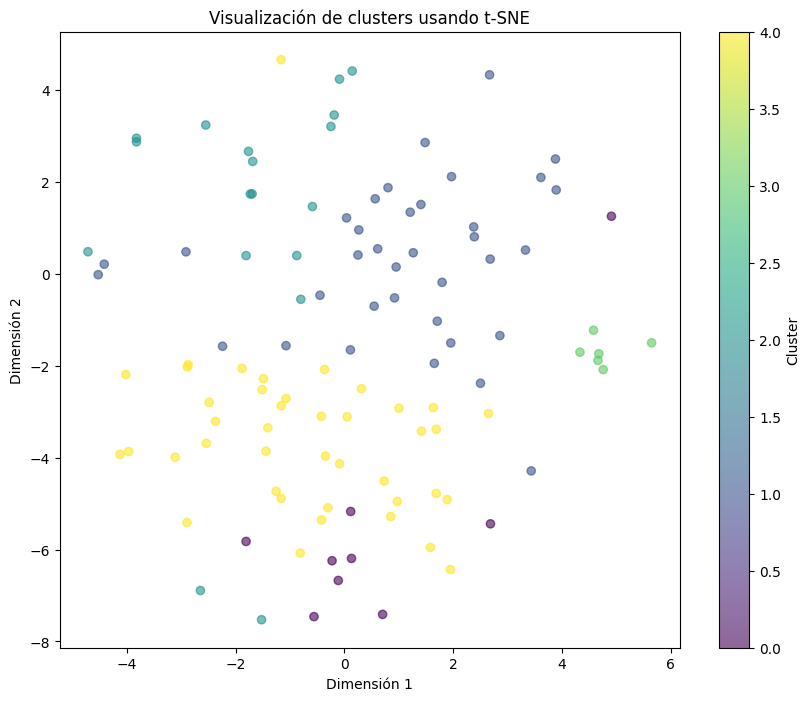


Cluster 0:
- La crisis creada por Petro con motivo de la repatriación de colombianos desde los Estados Unidos puso de presente su ineptitud para gobernar; bien fuere —como muchos lo han señalado en estos días acia...
- A nadie en Colombia le importaba hace algún tiempo la política exterior. Sin embargo, la gente ahora sabe que asuntos que antes se habrían considerado intrascendentes en ese campo, pueden tener efecto...
- Al finalizar cada año, se ha convertido en una tradición que la Policía Nacional, a través de su director, junto con los gobernadores y alcaldes de las ciudades capitales, presenten un informe de gest...

Cluster 1:
- El espectáculo deplorable que vimos durante el inédito consejo de ministros televisado es un calculado sainete tan malo que terminará siendo bueno. Me explico. ¿Qué fue lo que pasó? Tras lo ocurrido, ...
- “Dicen que yo he inventado el realismo mágico, pero solo soy el notario de la realidad. Incluso hay cosas reales que tengo que desechar porque sé que 

In [1]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Descargar recursos de NLTK (solo la primera vez)
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar el archivo JSON
with open('Noticias_Contenido.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extraer los textos de las columnas de opinión
texts = [item['content'] for item in data]

# Definir stopwords y lematizador
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Limpieza básica
    text = re.sub(r'\W', ' ', text)  # Elimina caracteres especiales
    text = re.sub(r'\d+', '', text)  # Elimina números
    text = text.lower()  # Convertir a minúsculas

    # Tokenización y limpieza
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Aplicar preprocesamiento a todos los textos
cleaned_texts = [preprocess_text(text) for text in texts]

# Cargar un modelo preentrenado (multilingüe)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Generar embeddings para cada texto
embeddings = model.encode(cleaned_texts)

# Guardar embeddings en un archivo .npy
np.save('embeddings.npy', embeddings)

# Guardar textos preprocesados en un archivo .txt
with open('cleaned_texts.txt', 'w', encoding='utf-8') as file:
    for text in cleaned_texts:
        file.write(text + '\n')

# 3. Reducción de dimensionalidad (PCA)
pca = PCA(n_components=50)  # Reducir a 50 dimensiones
embeddings_reduced = pca.fit_transform(embeddings)

# 4. Aplicación de clustering (K-Means)
num_clusters = 5  # Número de clusters (ajusta según sea necesario)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_reduced)

# Añadir los clusters al dataframe original (si lo tienes en un DataFrame)
# Si no, puedes crear un diccionario o lista para analizar los resultados
cluster_results = list(zip(texts, cleaned_texts, clusters))

# Guardar los resultados de clustering en un archivo
with open('cluster_results.txt', 'w', encoding='utf-8') as file:
    for text, cleaned_text, cluster in cluster_results:
        file.write(f"Cluster {cluster}:\n{text}\n\n")

# 5. Análisis de los clusters (visualización con t-SNE)
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_reduced)

# Graficar los clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Visualización de clusters usando t-SNE')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()

# Análisis de los clusters (interpretación)
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_samples = [text for text, _, cluster in cluster_results if cluster == cluster_id]
    for sample in cluster_samples[:3]:  # Mostrar los primeros 3 textos del cluster
        print(f"- {sample[:200]}...")  # Mostrar solo un fragmento de cada texto